In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
import bokeh
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'retina'}

In [2]:
hv.extension('bokeh', 'matplotlib',logo=False)
%opts Curve [width=600 height=350 tools=['hover'] ] {+framewise} VLine (color="black")
%opts Bars  [width=800 height=450 tools=['hover'] group_index=1 legend_position='top_left' xrotation=90]

# Exploring Data with Pandas.plot()

If your data is in a Pandas dataframe, it's natural to explore it using the ``.plot()`` method (based on Matplotlib).  Let's look at a [dataset of the number of cases of measles and pertussis (per 100,000 people) over time in each state](http://graphics.wsj.com/infectious-df-and-vaccines/#b02g20t20w15):

In [3]:
df = pd.read_csv('diseases.csv.gz')
df.head()

Year  Week    State  measles  pertussis
0  1928     1  Alabama     3.67        NaN
1  1928     2  Alabama     6.25        NaN
2  1928     3  Alabama     7.95        NaN
3  1928     4  Alabama    12.58        NaN
4  1928     5  Alabama     8.03        NaN

But with some Pandas operations we can pull out parts of the data that make sense to plot:

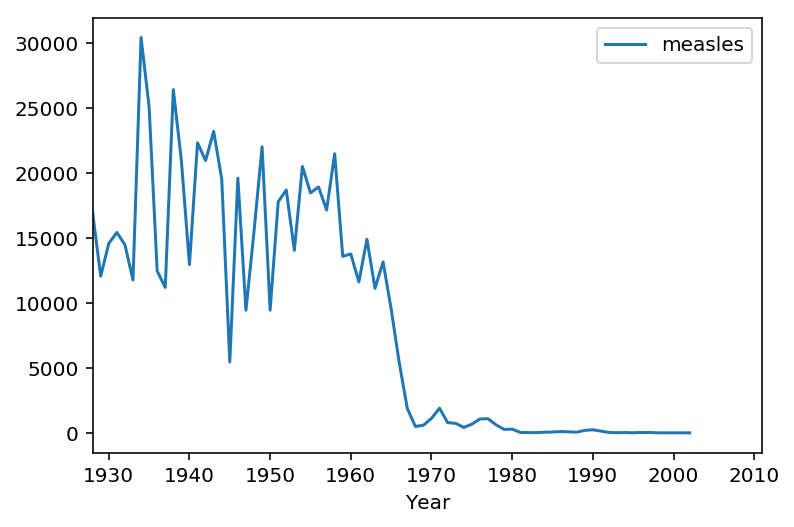

In [4]:
import numpy as np
measles_by_year = df[["Year","measles"]].groupby("Year").aggregate(np.sum)
measles_by_year.plot();

Here it is easy to see that the 1963 introduction of a measles vaccine brought the cases down to negligible levels.

# Exploring Data with %matplotlib inline 

Having done the work of isolating the data we want in its own dataframe, we can get the same plot using Matplotlib's syntax directly if we prefer:

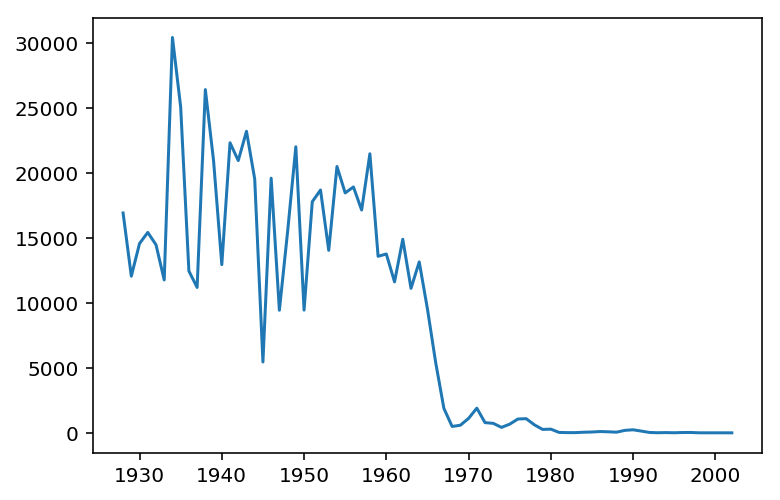

In [5]:
import matplotlib.pyplot as plt
plt.plot(measles_by_year);

By default, the tools below ignore the Pandas index, so we'll make it into a real column for the rest of this notebook:

In [6]:
measles_by_year = measles_by_year.reset_index()

# Exploring Data with HoloViews and Bokeh

The above plots are just static images, but it can be just as simple to get fully interactive plots in a web browser, with hover, pan, and zoom, by using HoloViews to get a Bokeh plot:

In [7]:
#hv.Curve(measles_by_year).opts(plot=dict(finalize_hooks=[disable_logo]))
hv.Curve(measles_by_year)

:Curve   [Year]   (measles)

Here [Bokeh](http://bokeh.pydata.org) makes rich JavaScript-based interactive plots from within Python, and [HoloViews](http://holoviews.org) provides a simple data-centric programming interface for doing so.

With HoloViews, you can easily add to the plot to capture your understanding as you explore:

In [8]:
m = hv.Curve(measles_by_year)  *  hv.VLine(1963)  *  hv.Text(1963, 27000, " Vaccine introduced", halign='left')
m

:Overlay
   .Curve.I :Curve   [Year]   (measles)
   .VLine.I :VLine   [x,y]
   .Text.I  :Text   [x,y]

while still always being able to access the original data involved for further analysis:

In [9]:
m.Curve.I.data.head()

Year   measles
0  1928  16924.34
1  1929  12060.96
2  1930  14575.11
3  1931  15427.67
4  1932  14481.11

And it's also easy to break down the data in different ways, such as to look at each state individually:

In [10]:
ds = hv.Dataset(df, ['Year', 'State'], 'measles').aggregate(function=np.sum)
measles_by_state = ds.to(hv.Curve, 'Year', 'measles')
measles_by_state * hv.VLine(1963)

:HoloMap   [State]
   :Overlay
      .Curve.I :Curve   [Year]   (measles)
      .VLine.I :VLine   [x,y]

Or to compare four states over time by overlaying:

In [11]:
states = ['New York', 'New Jersey', 'California', 'Texas']
measles_by_state.select(State=states, Year=(1930, 2005)).overlay() * hv.VLine(1963)

:Overlay
   .NdOverlay.I :NdOverlay   [State]
      :Curve   [Year]   (measles)
   .VLine.I     :VLine   [x,y]

Or by faceting:

In [12]:
%%opts Curve [width=200, height=100]
measles_by_state.select(State=states, Year=(1930, 2005)).grid('State') * hv.VLine(1963)

:GridSpace   [State]
   :Overlay
      .Curve.I :Curve   [Year]   (measles)
      .VLine.I :VLine   [x,y]

Or as Bars or many other types of plots:

In [13]:
ds.select(State=states, Year=(1980, 1990)).to(hv.Bars, ['Year', 'State'], 'measles').sort()

:Bars   [Year,State]   (measles)

Or make summaries of the entire dataset with error bars:

In [14]:
agg = ds.aggregate('Year', function=np.mean, spreadfn=np.std)
(hv.Curve(agg) * hv.ErrorBars(agg,vdims=['measles', 'measles_std'])).redim.range(measles=(0, None)) * hv.VLine(1963)

:Overlay
   .Curve.I     :Curve   [Year]   (measles,measles_std)
   .ErrorBars.I :ErrorBars   [Year]   (measles,measles_std)
   .VLine.I     :VLine   [x,y]

The various faceting methods even compose together, meaning that if we had more independent dimensions in our dataset we could ``.overlay`` one of them, ``.grid`` another, and have widgets for any other remaining key dimensions.  In this way we can explore even very high dimensional datasets.

If we really want to invest a lot of time in making a fancy plot, we can customize it to try to show *all* the yearly data about measles at once:

In [15]:
url = 'https://raw.githubusercontent.com/blmoore/blogR/master/data/measles_incidence.csv'
data = pd.read_csv(url, skiprows=2, na_values='-')

yearly_data = data.drop('WEEK', axis=1).groupby('YEAR').sum().reset_index()
measles = pd.melt(yearly_data, id_vars=['YEAR'], var_name='State', value_name='Incidence')

heatmap = hv.HeatMap(measles, label='Measles Incidence')
aggregate = hv.Dataset(heatmap).aggregate('YEAR', np.mean, np.std)

marker = hv.Text(1963, 800, u'\u2193 Vaccine introduced', halign='left')

agg = hv.ErrorBars(aggregate) * hv.Curve(aggregate).opts(plot=dict(xrotation=90))

hm_opts = dict(width=900, height=500, tools=['hover'], logz=True, invert_yaxis=True,
               xrotation=90, labelled=[], toolbar='above', xaxis=None)
overlay_opts = dict(width=900, height=200, show_title=False)
vline_opts = dict(line_color='black')

opts = {'HeatMap': {'plot': hm_opts}, 'Overlay': {'plot': overlay_opts}, 'VLine': {'style': vline_opts}}

(heatmap + agg * marker).opts(opts).cols(1)

:Layout
   .HeatMap.Measles_Incidence :HeatMap   [YEAR,State]   (Incidence)
   .Overlay.Measles_Incidence :Overlay
      .ErrorBars.Measles_Incidence :ErrorBars   [YEAR]   (Incidence,Incidence_std)
      .Curve.Measles_Incidence     :Curve   [YEAR]   (Incidence,Incidence_std)
      .Text.I                      :Text   [x,y]

By the way, the only thing about any of this that's specific to Bokeh is being able to interact with elements of the plot; HoloViews can use Matplotlib instead of Bokeh to generate any of the plots if we don't need zoom, hover, etc.:

:HoloMap   [State]
   :Overlay
      .Curve.I :Curve   [Year]   (measles)
      .VLine.I :VLine   [x,y]
      .Text.I  :Text   [x,y]
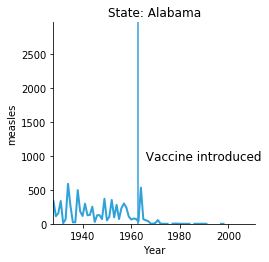
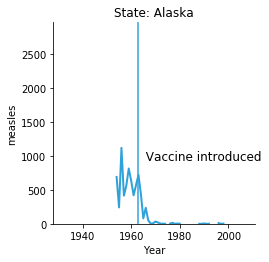
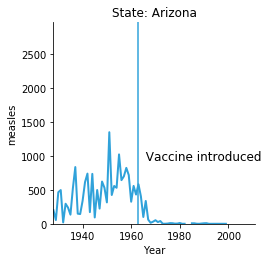
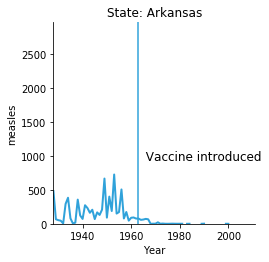
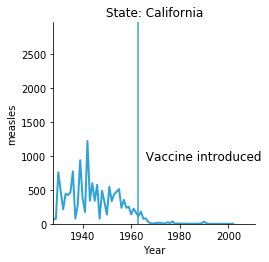
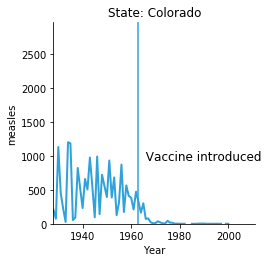
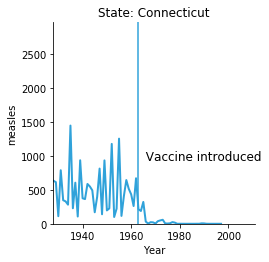
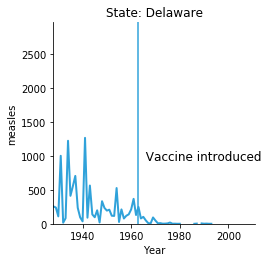
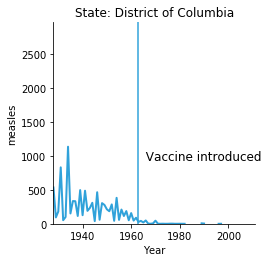
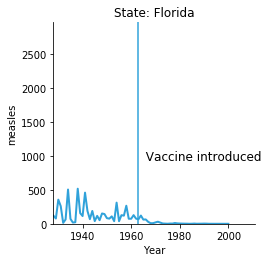
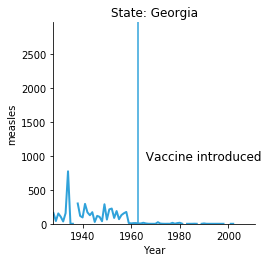
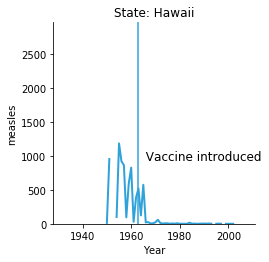
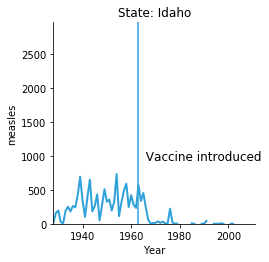
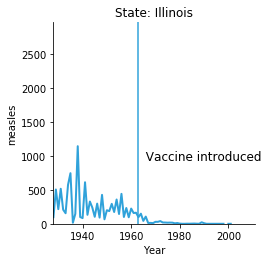
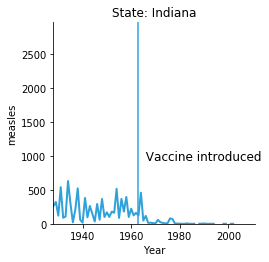
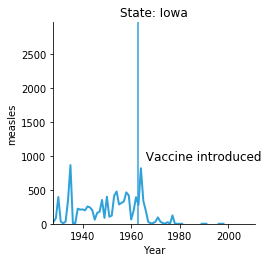
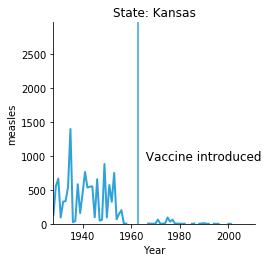
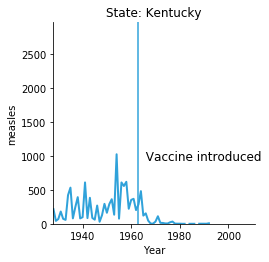
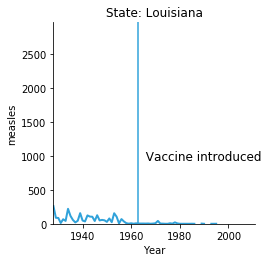
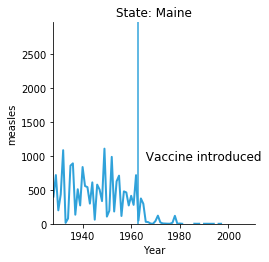
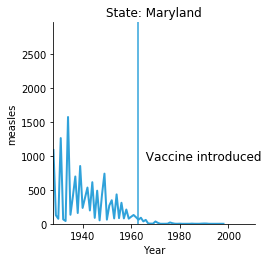
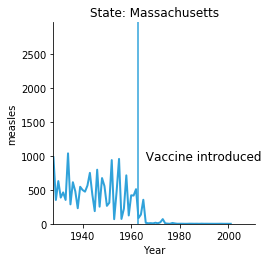
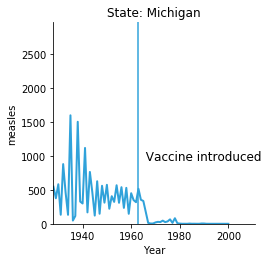
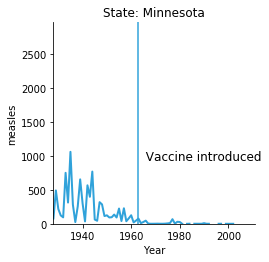
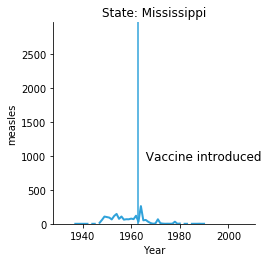
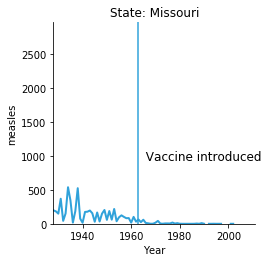
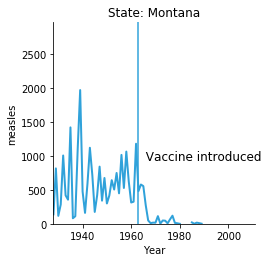
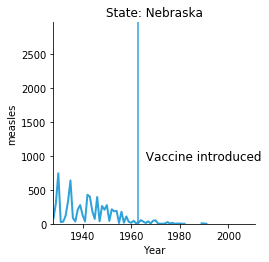
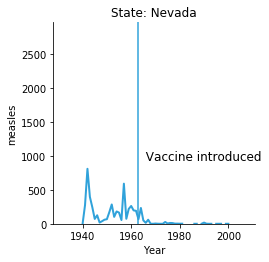
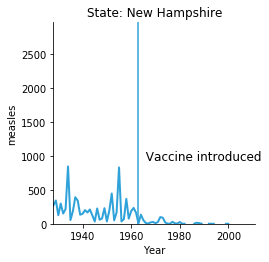
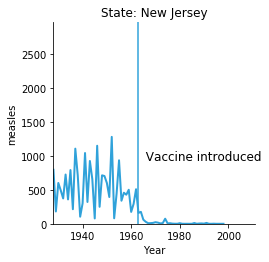
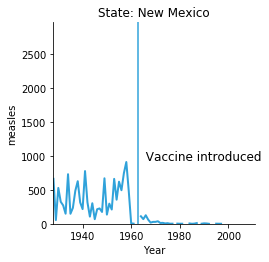
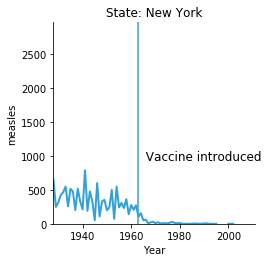
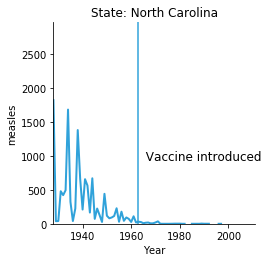
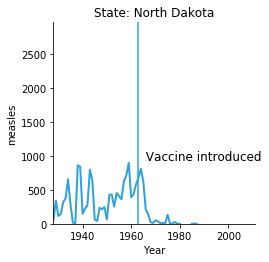
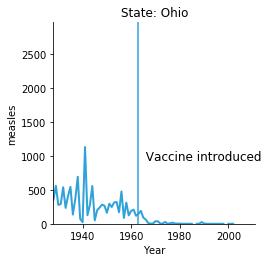
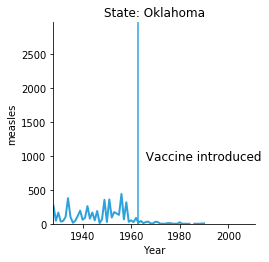
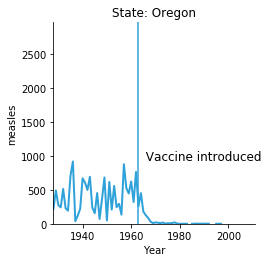
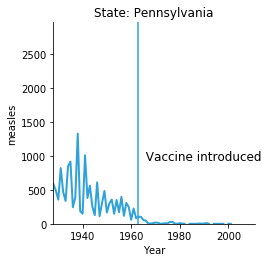
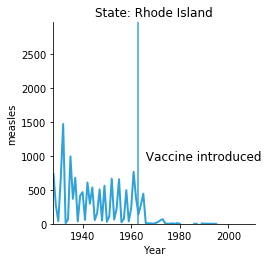
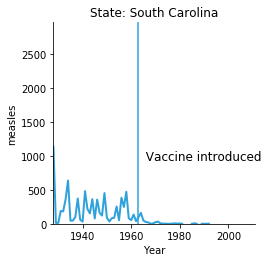
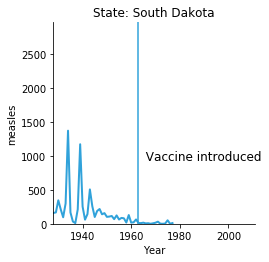
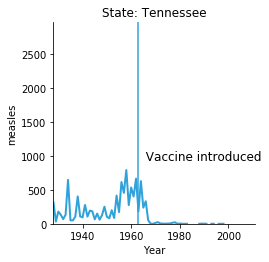
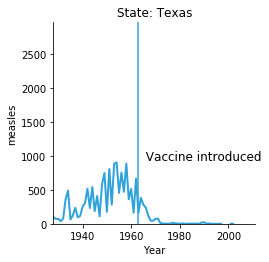
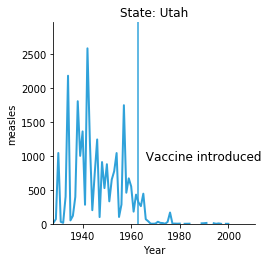
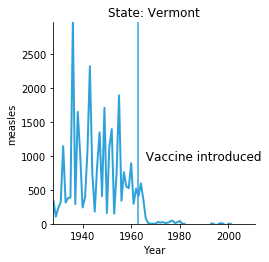
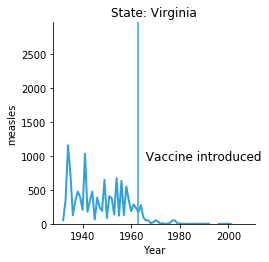
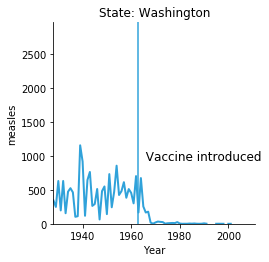
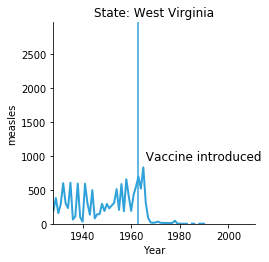
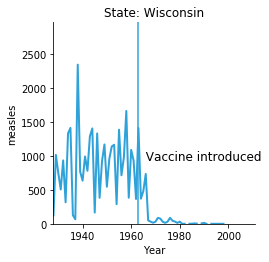
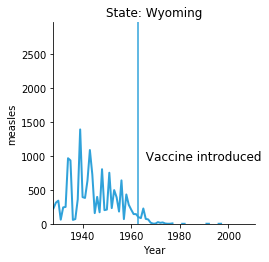

In [16]:
%%output backend='matplotlib' 
measles_by_state * hv.VLine(1963) * hv.Text(1963, 1000, "  Vaccine introduced", halign='left')

As you can see, there are lots of options for getting quick plots to explore your data in a browser, and if you choose HoloView+Bokeh plots, you can have full interactivity with very little code to explore even quite complex datasets.

# Seaborn statistical plots

Seaborn is based on Matplotlib, offering easy-to-contruct statistical visualizations.

In [17]:
from holoviews.operation import gridmatrix
import seaborn as sns

sns.set(style="ticks", color_codes=True)
iris = sns.load_dataset("iris")
iris.tail()

sepal_length  sepal_width  petal_length  petal_width    species
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

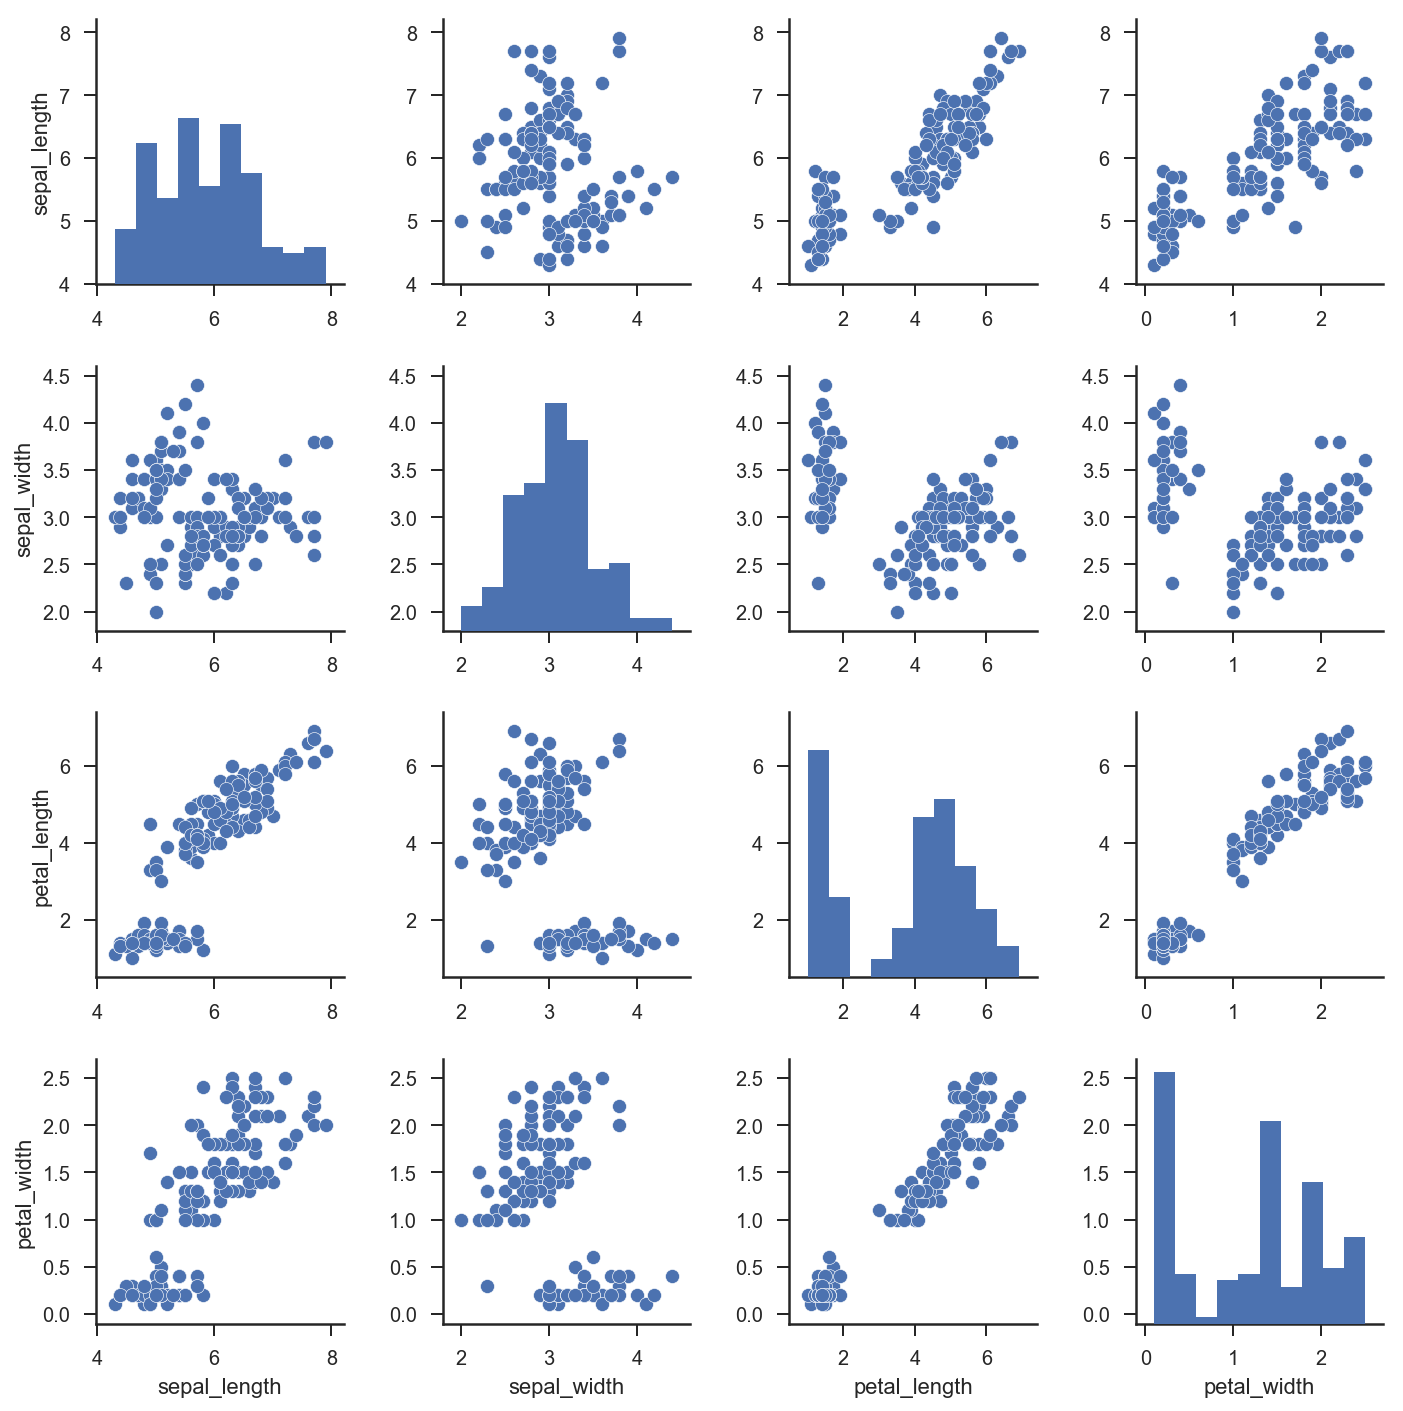

In [18]:
sns.pairplot(iris);

## HoloViews + Bokeh statistical plots

HoloViews includes most of the capabilities from Seaborn, with the advantage that they are richly interactive:

In [19]:
%%opts Bivariate [bandwidth=0.5] (cmap='Blues') Points (size=2)
%%opts Points    [tools=['box_select']]

iris_ds = hv.Dataset(iris)

density_grid = gridmatrix(iris_ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(iris_ds, chart_type=hv.Points)

density_grid * point_grid

:GridMatrix   [X,Y]
   :Overlay
      .Distribution.I :Distribution   [sepal_width]   (Density)
      .Histogram.I    :Histogram   [sepal_width]   (sepal_width_frequency)

In [20]:
%%opts Bivariate [bandwidth=0.5]        (cmap=Cycle(values=['Blues', 'Reds', 'Oranges'])) 
%%opts Points    [tools=['box_select']] (size=2 alpha=0.7)
%%opts NdOverlay [batched=False]

iris_ds = hv.Dataset(iris).groupby('species').overlay()

density_grid = gridmatrix(iris_ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(iris_ds, chart_type=hv.Points)

density_grid * point_grid

:GridMatrix   [X,Y]
   :Overlay
      .NdOverlay.I  :NdOverlay   [species]
         :Distribution   [sepal_width]   (Density)
      .NdOverlay.II :NdOverlay   [species]
         :Histogram   [sepal_width]   (sepal_width_frequency)